In [1]:
import pandas as pd
import numpy as np 
import xgboost as xgb 
from sklearn.datasets import load_boston 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from  sklearn.metrics  import r2_score
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importação e Leitura dos Dados

In [2]:
df_train = pd.read_csv('regression_train.csv')
df_test = pd.read_csv('regression_test.csv')

# 2. Análise dos Dados

A seguir, é possível visualizar os 5 primeiros registros do conjunto de dados de treino, para analisar o comportamento e formatação dos valores.

In [3]:
df_train.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680


Também serão utilizados os métodos .describe() e .info(), para analisar os valores de cada variável, tanto na base de treino quanto na base de teste.

In [4]:
df_train.describe()

,target,X1,X2,X3,X4,X5,X6,X7
count,715.000000,1042.000000,1031.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000
mean,1349.940229,2.421925,-0.460781,52.094329,2.462871,-65.284233,4.381958,-1.287435
std,1593.201095,3.182976,4.426286,31.374828,2.541632,9.033489,3.290306,11.066380
min,0.062551,-8.699406,-13.651540,38.035456,0.002360,-121.450423,0.000000,-69.835905
25%,230.632308,0.170590,-3.307931,47.087106,0.671196,-69.126630,0.000000,-7.830007
50%,808.374368,2.508671,-0.461150,49.972867,1.652609,-65.360660,5.000000,-1.074191
75%,1849.754221,4.540218,2.406651,52.674305,3.361181,-61.187635,8.000000,5.659476
max,10382.469480,12.380693,12.926106,500.000000,18.813009,53.919202,8.000000,30.376348


In [5]:
df_test.describe()

,target,X1,X2,X3,X4,X5,X6,X7
count,180.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,1083.167620,2.118804,-0.729926,50.019371,2.570686,-65.634193,4.153257,-1.896956
std,1266.764414,2.924070,4.065920,4.109684,2.456733,7.827388,3.345416,10.133573
min,0.619759,-7.187993,-12.530861,38.282205,0.017793,-123.280755,0.000000,-56.751775
25%,203.306229,0.220241,-3.113019,47.368662,0.798704,-69.361831,0.000000,-7.315595
50%,623.905972,2.038765,-0.816475,50.070453,1.824582,-65.517502,5.000000,-1.918715
75%,1522.742335,4.008733,1.836272,52.659709,3.587555,-61.681399,8.000000,4.315239
max,8270.877273,9.586412,11.610249,65.704951,16.798910,-43.237419,8.000000,27.284085


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
target    715 non-null float64
X1        1042 non-null float64
X2        1031 non-null float64
X3        1042 non-null float64
X4        1042 non-null float64
X5        1042 non-null float64
X6        1042 non-null int64
X7        1042 non-null float64
dtypes: float64(7), int64(1)
memory usage: 65.2 KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
target    180 non-null float64
X1        261 non-null float64
X2        261 non-null float64
X3        261 non-null float64
X4        261 non-null float64
X5        261 non-null float64
X6        261 non-null int64
X7        261 non-null float64
dtypes: float64(7), int64(1)
memory usage: 16.4 KB


Com as informações mostradas acima, é possível visualizar há valores nulos tanto na variável "target" quanto na variável "X2". Apesar do modelo escolhido, XGboost, conseguir trabalhar com valores ausentes, esses valores podem atrapalhar a previsão, por isto, será necessário eliminar esses valores só data frame.

In [8]:
df_train = df_train.dropna(subset=['X2','target'])
df_test = df_test.dropna(subset=['target'])

Agora será preciso dividir os data frames em variáveis independentes e dependentes. Abaixo pode observado o processo.

In [9]:
# Variáveis de Treino
X_train = df_train[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']]
y_train = df_train['target']
# Variáveis de Teste
X_test = df_test[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']]
y_test = df_test['target']

Como o modelo utilizado é baseado em árvores e não em distâncias, não é necessário realizar a normalização dos valores.

# 3. Treinamento

Na fase de treinamento, é ideal que se utilize os parâmetros mais adequados para o problema, para evitar overfitting e underfitting, e obter os melhores resultado possíveis. Neste caso, para o modelo proposto, será realizado ajustes nos parâmentros learning_rate, max_depth, n_estimators e min_child_weight. Para avaliar e obter os melhores valores, será utilizada a métrica Root Mean Square Error(RMSE).

Melhor n_estimators: 0.246 | Melhor RMSE: 98.01107902415909


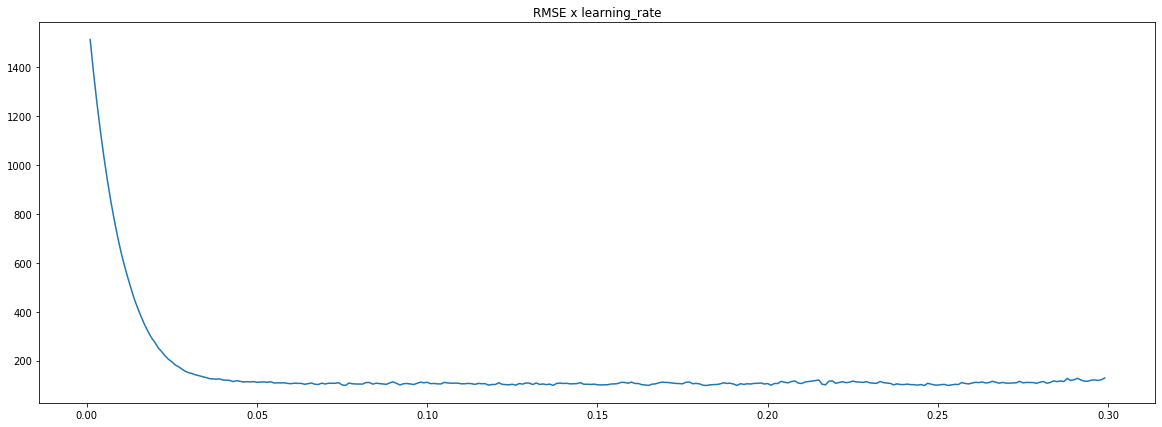

In [10]:
# Avaliando o parâmetro learning_rate
range_learning_rate = np.arange(0.001,0.3,step=0.001)
list_rmse=[]

for value in range_learning_rate:
    reg_xgb = xgb.XGBRegressor (learning_rate=value)
    reg_xgb.fit(X_train, y_train)
    y_pred = reg_xgb.predict(X_test)
    list_rmse.append(sqrt(mean_squared_error (y_test, y_pred)))
    
best_rmse=min(list_rmse)
index = list_rmse.index(best_rmse)
best_learning_rate = range_learning_rate[index]

print('Melhor n_estimators: ' + str(best_learning_rate) + ' | Melhor RMSE: '+ str(best_rmse))    

plt.figure(figsize=(20,7))
sns.lineplot(x=range_learning_rate,y=list_rmse).set_title('RMSE x learning_rate');    

Melhor max_depth: 3 | Melhor RMSE: 93.20054409516085


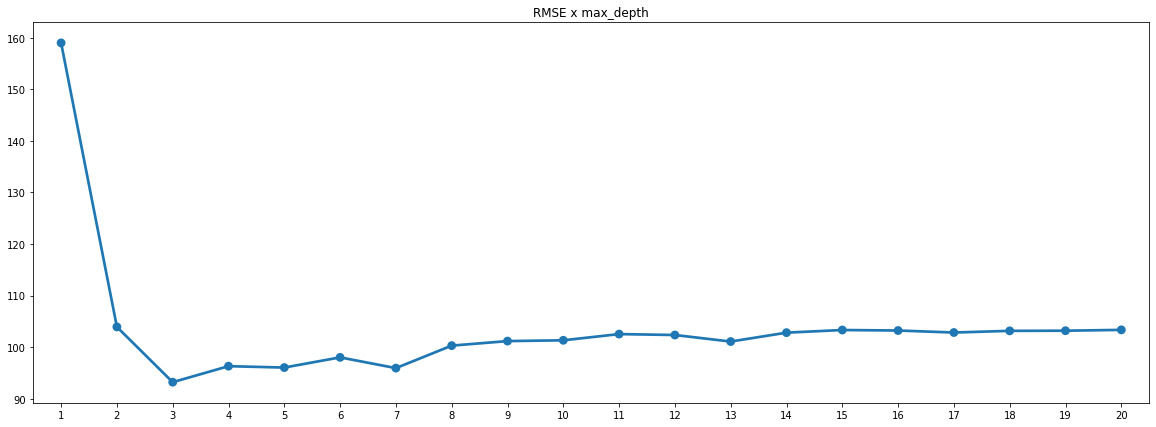

In [11]:
# Avaliando o parâmetro max_depth
range_max_depth = np.arange(1,21)
list_rmse=[]

for value in range_max_depth:
    reg_xgb = xgb.XGBRegressor (learning_rate=0.246 ,max_depth=value)
    reg_xgb.fit(X_train, y_train)
    y_pred = reg_xgb.predict(X_test)
    list_rmse.append(sqrt(mean_squared_error (y_test, y_pred)))
    
best_rmse=min(list_rmse)
index = list_rmse.index(best_rmse)
best_max_depth = range_max_depth[index]

print('Melhor max_depth: ' + str(best_max_depth) + ' | Melhor RMSE: '+ str(best_rmse))    

plt.figure(figsize=(20,7))
sns.pointplot(x=range_max_depth, y=list_rmse).set_title('RMSE x max_depth');    

Melhor n_estimators: 970 | Melhor RMSE: 86.4237213743874


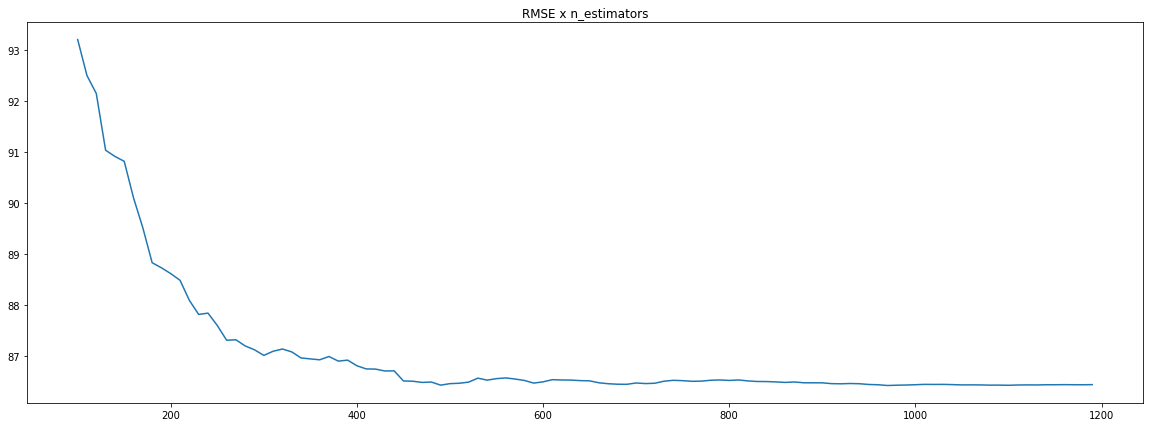

In [12]:
# Avaliando o parâmetro n_estimators
range_n_estimators = np.arange(100,1200,step=10)
list_rmse=[]

for value in range_n_estimators:
    reg_xgb = xgb.XGBRegressor (learning_rate=0.246 ,max_depth=3, n_estimators=value)
    reg_xgb.fit(X_train, y_train)
    y_pred = reg_xgb.predict(X_test)
    list_rmse.append(sqrt(mean_squared_error (y_test, y_pred)))
    
best_rmse=min(list_rmse)
index = list_rmse.index(best_rmse)
best_n_estimators = range_n_estimators[index]

print('Melhor n_estimators: ' + str(best_n_estimators) + ' | Melhor RMSE: '+ str(best_rmse))    

plt.figure(figsize=(20,7))
sns.lineplot(x=range_n_estimators,y=list_rmse).set_title('RMSE x n_estimators');    

Melhor min_child_weight: 8 | Melhor RMSE: 78.96630645564811


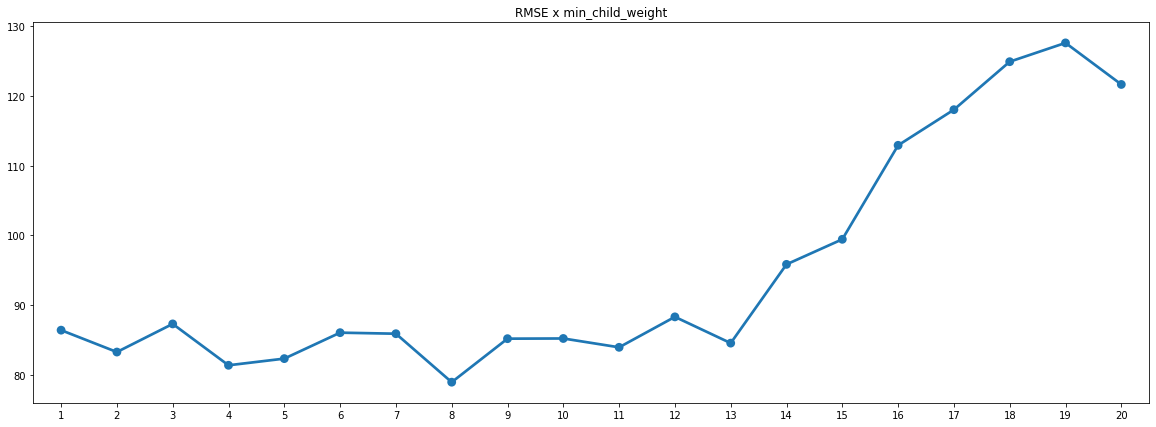

In [13]:
# Avaliando o parâmetro min_child_weight
range_min_child_weight = np.arange(1,21)
list_rmse=[]

for value in range_min_child_weight:
    reg_xgb = xgb.XGBRegressor (learning_rate=0.246 ,max_depth=3, n_estimators=970, min_child_weight=value)
    reg_xgb.fit(X_train, y_train)
    y_pred = reg_xgb.predict(X_test)
    list_rmse.append(sqrt(mean_squared_error (y_test, y_pred)))
    
best_rmse=min(list_rmse)
index = list_rmse.index(best_rmse)
best_min_child_weight = range_min_child_weight[index]

print('Melhor min_child_weight: ' + str(best_min_child_weight) + ' | Melhor RMSE: '+ str(best_rmse))    

plt.figure(figsize=(20,7))
sns.pointplot(x=range_min_child_weight,y=list_rmse).set_title('RMSE x min_child_weight');

Após a análise e obtenção dos valores, o treinamento será realizado utilizando os melhores parâmetros avaliados: learning_rate=0.246 ,max_depth=3, n_estimators=970 e min_child_weight=8.

In [14]:
reg_xgb = xgb.XGBRegressor (learning_rate=0.246 ,max_depth=3, n_estimators=970, min_child_weight=8)
reg_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.246, max_delta_step=0, max_depth=3,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=970, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# 4. Previsão

Após o treinamento, com os parâmetros encontrado, será realizada a regressão. A seguir é possível visualizar o processo.

In [15]:
y_pred = reg_xgb.predict(X_test)

# 5. Avaliação dos modelos

Nesta sessão, é possível avaliar os resultados do modelo. foram utilizada as métricas RMSE, R², MSE, RMSPE(RMSE%) e Correlação(Cor).

In [16]:
mse = mean_squared_error (y_test, y_pred)
r2 = r2_score(y_test,y_pred)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmspe = np.sqrt(np.mean(np.square(((y_test - y_pred) / y_test)), axis=0))
cor = np.corrcoef(y_test, y_pred)[0,1]

In [17]:
print('MSE: ' + str(mse))
print('RMSE: ' + str(rmse))
print('RMSE%: ' + str(rmspe))
print('R²: ' + str(r2))
print('Cor: ' + str(cor))

MSE: 6235.677555247332
RMSE: 78.96630645564811
RMSE%: 4.583635000567731
R²: 0.9960923881804993
Cor: 0.9980593043525711


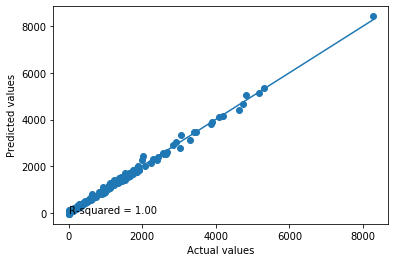

In [18]:
# plot regression
r_squared = r2
plt.scatter(y_test,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))

plt.text(0.6, 0.5, 'R-squared = %0.2f' % r_squared);

# 6. Importância das Variáveis

Abaixo é possivel visualizar que a variável "X2" é a que apresenta o maior nível de importância, de acordo com o modelo. para isto, foi necessário utilizar o método "feature_importances_", do modelo XGboost, que mostra a importâncias de variáveis baseadas em impurezas, junto com sua variabilidade entre árvores.

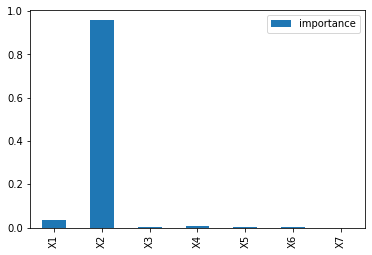

In [19]:
feature_importance = pd.DataFrame(reg_xgb.feature_importances_.reshape(1, -1), columns=X_train.columns, index = ['importance']).transpose()
feature_importance.plot.bar();